In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output
from tqdm.notebook import tqdm
import os
from pathlib import Path

import torch
import numpy as np

import cv2
import matplotlib.pyplot as plt

In [2]:
PYTHON_PATHS = ["../.."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
        

from imap.utils import UniversalFactory
from pytorch_lightning.utilities.parsing import AttributeDict

# Test Dataset Images

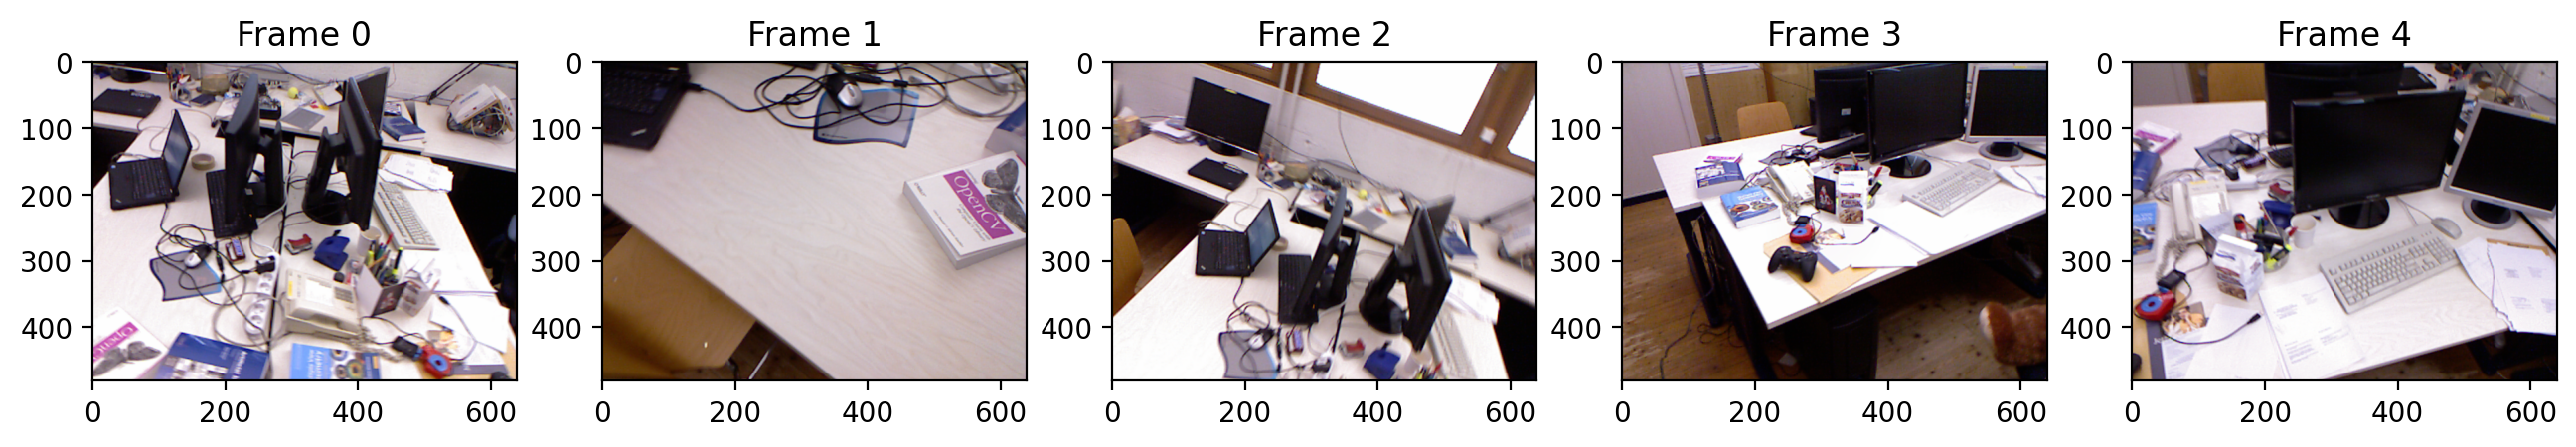

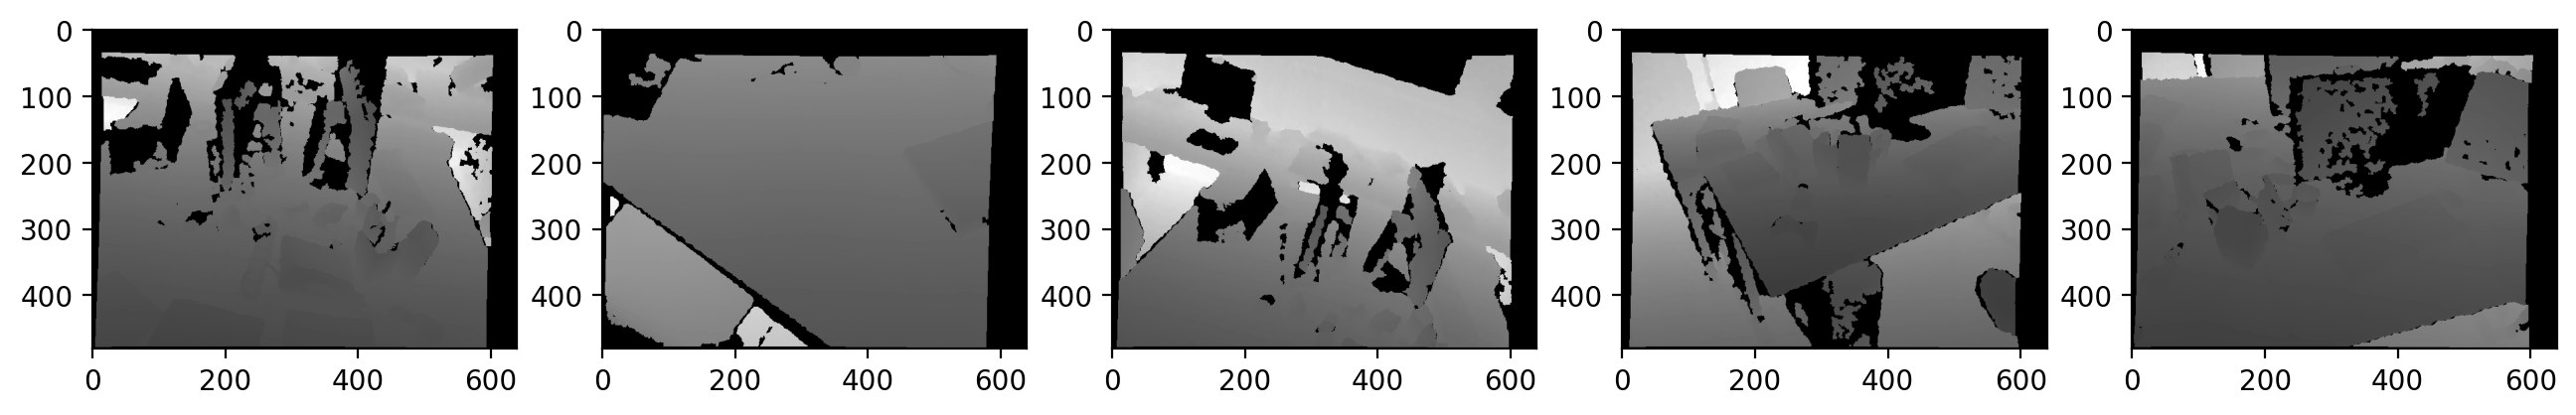

In [3]:
frames = [0, 2]
test_images_list = [
"1305031458.159638.png", "1305031462.692548.png", "1305031464.959763.png","1305031467.695886.png",  "1305031469.296754.png"
]
test_depthes_list = [
    "1305031458.144808.png", "1305031462.680788.png", "1305031464.952471.png", "1305031467.686044.png", "1305031469.288263.png"
]

figure = plt.figure(dpi=200, figsize=(16,10))

for i in range(len(test_images_list)):
    
    color_image_path = str(Path(f"../../tests/datasets/tum rgbd/rgbd_dataset_freiburg1_desk/rgb/{test_images_list[i]}"))
    color_image = cv2.imread(color_image_path)
    plt.subplot(1,5,i+1)
    plt.title(f'Frame {i}')
    plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR))


    
figure = plt.figure(dpi=200, figsize=(16,10))
factor = 5000 # for the 16-bit PNG files
# OR: factor = 1 # for the 32-bit float images in the ROS bag files
for i in range(len(test_images_list)):
    
    depth_image_path = str(Path(f"../../tests/datasets/tum rgbd/rgbd_dataset_freiburg1_desk/depth/{test_depthes_list[i]}"))
    depth_image = cv2.imread(depth_image_path, -1).astype(np.float32) / factor
    depth_image = np.clip(depth_image, 0, 4)
    plt.subplot(1,5,1+i)
    plt.imshow(depth_image, cmap="gray")
    

# Create Dataset Loader

In [4]:
from imap.data.datasets.tum.tum_dataset_loader_factory import TUMDatasetLoaderFactory
from imap.model.input.model_buffer_input import ModelBufferInput
from imap.model.primitives import State, Frame

In [5]:
dataset_params = {'dataset_path': "../../tests/datasets/tum rgbd/", 
                  'scene_name': "rgbd_dataset_freiburg1_desk", 
                  'association_file_name': "data_association_file.txt", 
                  'frame_indices': [131, 257, 325, 407, 455],
                  'distance_koef': 0.1,
                  'clip_distance_threshold': 4.}
camera, dataset_loader = TUMDatasetLoaderFactory.make_dataset_loader(**dataset_params)

Reading ../../tests/datasets/tum rgbd/rgbd_dataset_freiburg1_desk/data_association_file.txt


# Create Model

In [6]:
from imap.model.nerf import NERF
from imap.model.embeddings.gaussian_positional_encoding import GaussianPositionalEncoding

In [7]:
model_parameters = AttributeDict(
    name="NERF",
    course_sample_bins=32,
    fine_sample_bins=12,
    depth_loss_koef=1.,
    color_loss_koef=5.,
    minimal_depth=0.01,
    positional_embedding = AttributeDict(
                                        name = 'GaussianPositionalEncoding',
                                        encoding_dimension=92,
                                        sigma=25,
                                        use_only_sin=True
                                        )
)

factory = UniversalFactory([NERF, GaussianPositionalEncoding])
model = factory.make_from_parameters(model_parameters, camera_info=camera)

# Train the Model

In [8]:
from imap.trainers.trainers import ModelTrainer

In [9]:
model = model.to('cuda')
model.train()
trainer = ModelTrainer(model, lr=0.01)
num_epochs = 300
points_per_image = int(640 * 480 / 100)


model_buffer_input = ModelBufferInput(points_per_frame=points_per_image)

for i in tqdm(range(num_epochs)):
    # update model input buffer
    for color_image, depth_image, position in dataset_loader:
        color_image = camera.process_color_image(color_image)
        depth_image = camera.process_depth_image(depth_image)[0]
        position = camera.process_positions(position)
        
        frame = Frame(color_image, depth_image)
        state = State(frame, position)
        model_buffer_input.update_data(state)
    # train the model
    for batch in model_buffer_input:
        loss = trainer.train(model, batch)
    # trainer.reset_params()
    
    if i%5 == 0:
        print(f"loss {loss}")
    # clear_output(wait=True)
    
torch.cuda.empty_cache()

  0%|          | 0/300 [00:00<?, ?it/s]

loss 2.1058146953582764
loss 2.1620850563049316
loss 1.0690429210662842
loss 1.0584582090377808
loss 0.9549065828323364
loss 0.9206022620201111
loss 0.8779827356338501
loss 0.8707551956176758
loss 0.8433288335800171
loss 0.8618170619010925
loss 0.8665652275085449
loss 0.794087290763855
loss 0.8099243640899658
loss 0.814492404460907
loss 0.840732991695404
loss 0.8023184537887573
loss 0.7963161468505859
loss 0.7730551958084106
loss 0.809285581111908
loss 0.7218599319458008
loss 0.7959861755371094
loss 0.8020691275596619
loss 0.7565978765487671
loss 0.7122651934623718
loss 0.6880962252616882
loss 0.6989003419876099
loss 0.6907472610473633
loss 0.8007534742355347
loss 0.7549793720245361
loss 0.6631944179534912
loss 0.6925975680351257
loss 0.8675537109375
loss 0.7758919596672058
loss 0.6311053037643433
loss 0.7625905871391296
loss 0.6139929890632629
loss 0.6336435079574585
loss 0.6456040143966675
loss 0.6538420915603638
loss 0.6105151176452637
loss 0.6854062080383301
loss 0.6418208479881287

# Show the results

In [15]:
from imap.utils.utils import *

In [16]:
# prepare image coordinates

scale = 1
height = color_image.shape[0]
width = color_image.shape[1]
x, y = generate_image_meshgrid(height, width, scale)
np_pixels = get_pixels_from_meshgrid(x, y, scale)


In [17]:
# positions for rendering
positions = []
for _, _, position in dataset_loader:
    color_image = camera.process_color_image(color_image)
    depth_image = camera.process_depth_image(depth_image)[0]
    positions.append(camera.process_positions(position))

In [18]:
# reder the image

batch_size = 4096

model = model.cuda()
model.eval()


pixels = torch.from_numpy(np_pixels).cuda()

color_coarse_images = []
depth_coarse_images =[]
color_fine_images = []
depth_fine_images = []

mean = camera._color_mean
std = camera._color_std

with torch.no_grad():
    for pos in positions:
        position = torch.from_numpy(pos).to('cuda')
        output_coarse_color = []
        output_coarse_depth = []
        output_fine_color = []
        output_fine_depth = []

        for i in tqdm(range(pixels.shape[0] // batch_size)):
            output = model(pixels[i * batch_size:i * batch_size + batch_size],
                                 position)
            output_coarse_color.append(output[0])
            output_coarse_depth.append(output[1])
            output_fine_color.append(output[2])
            output_fine_depth.append(output[3])

        reconstructed_image = torch.cat(output_coarse_color, dim=0).reshape(480 // scale, 640 // scale, 3).detach().cpu().numpy()
        reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
        reconstructed_image = np.clip(reconstructed_image / 255., 0, 1).astype(np.float32)
        color_coarse_images.append(reconstructed_image)
        
        reconstructed_image = torch.cat(output_fine_color, dim=0).reshape(480 // scale, 640 // scale, 3).detach().cpu().numpy()
        reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
        reconstructed_image = np.clip(reconstructed_image / 255., 0, 1).astype(np.float32)
        color_fine_images.append(reconstructed_image)
        
        reconstructed_depth = torch.cat(output_coarse_depth, dim=0).reshape(480 // scale, 640 // scale).detach().cpu().numpy()
        depth_coarse_images.append(reconstructed_depth)
        
        
        reconstructed_depth = torch.cat(output_fine_depth, dim=0).reshape(480 // scale, 640 // scale).detach().cpu().numpy()
        depth_fine_images.append(reconstructed_depth)

del output_coarse_color, output_coarse_depth, output_fine_color, output_fine_depth, position, pixels
torch.cuda.empty_cache()

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

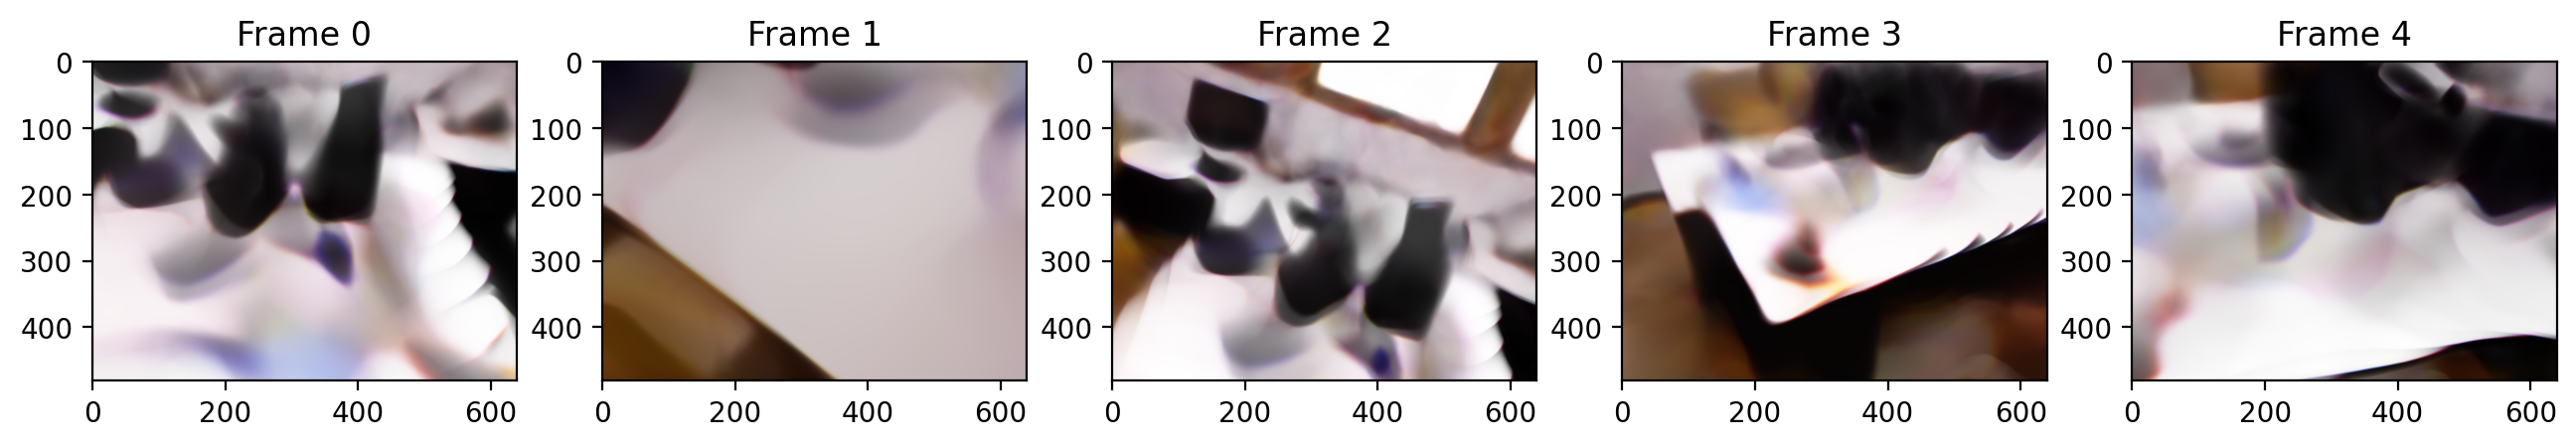

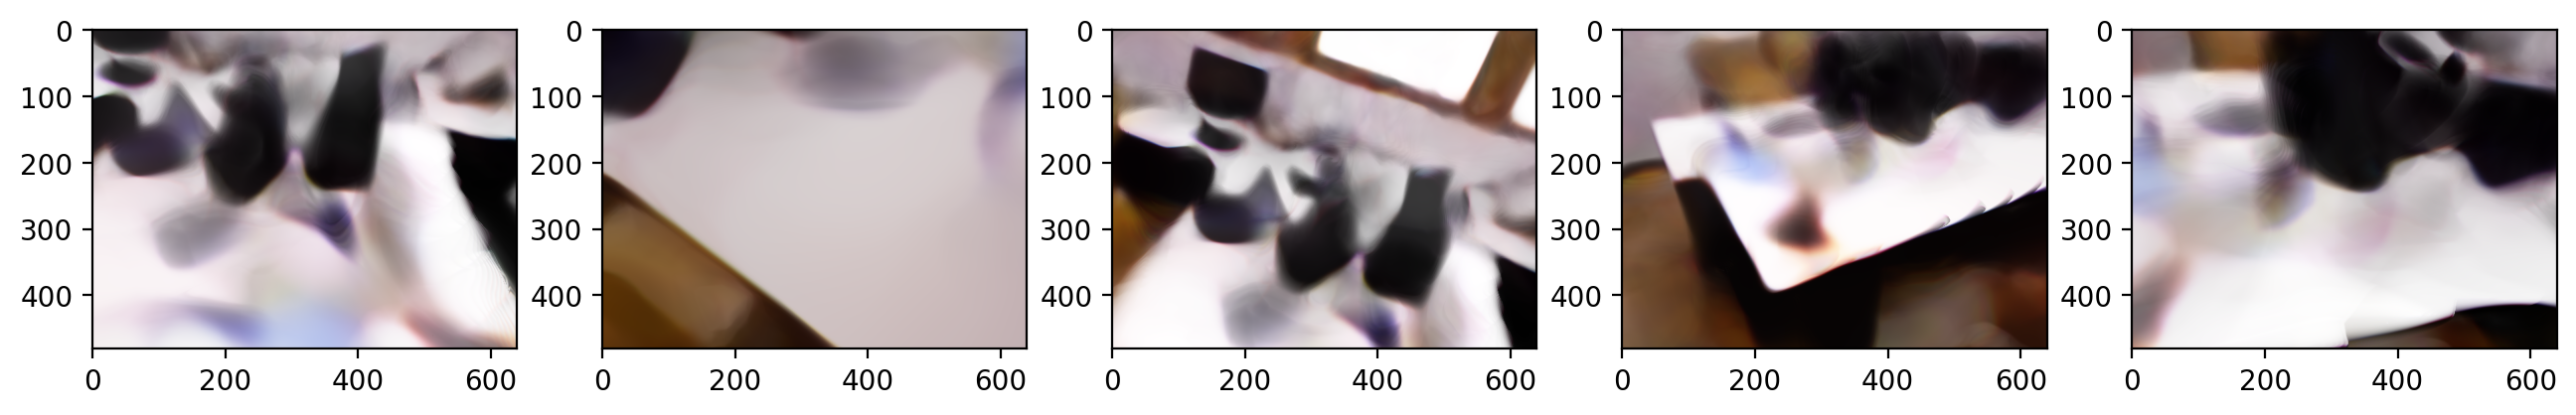

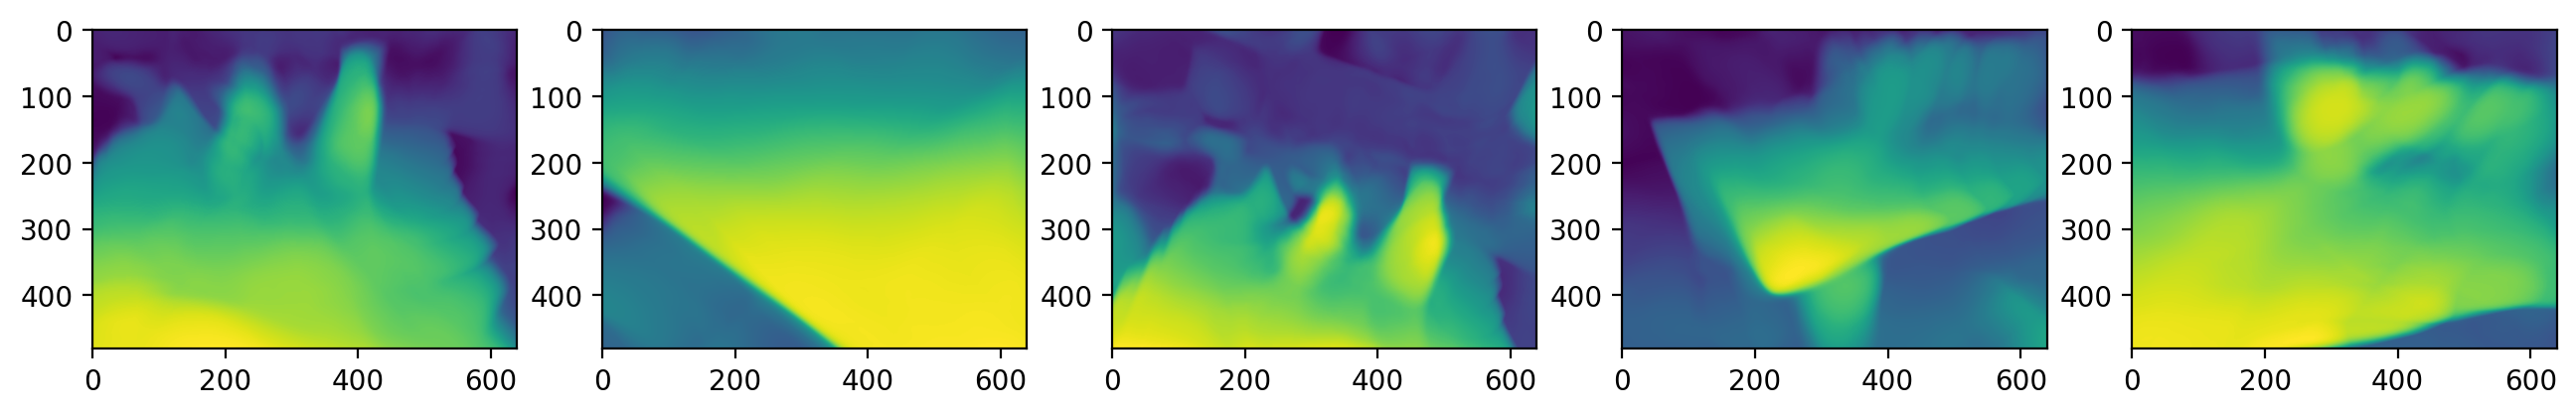

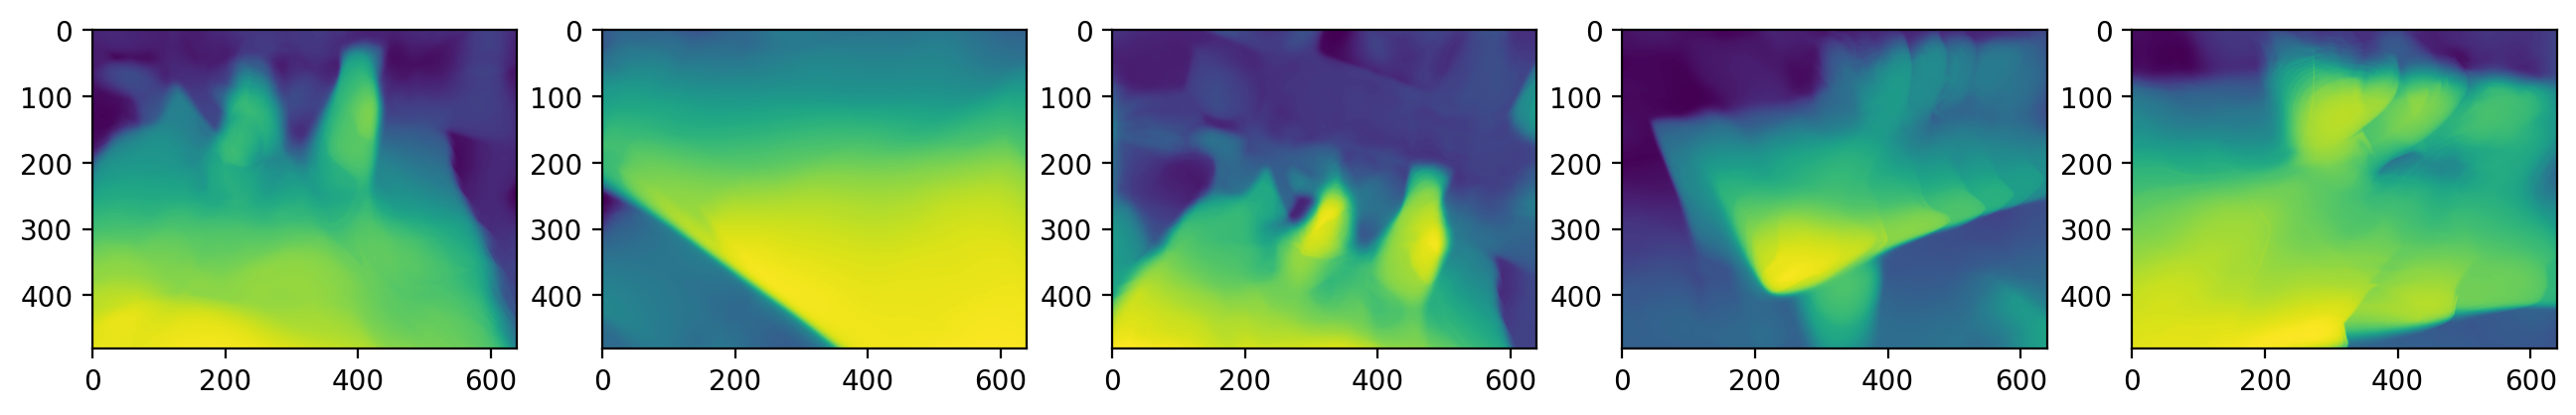

In [19]:
figure = plt.figure(dpi=200, figsize=(16,10))
for i in range(len(positions)):
    plt.subplot(1,len(positions),i+1)
    plt.title(f'Frame {i}')
    plt.imshow(cv2.cvtColor(color_coarse_images[i], cv2.COLOR_RGB2BGR))

figure = plt.figure(dpi=200, figsize=(16,10))
for i in range(len(positions)):
    plt.subplot(1,len(positions),i+1)
    plt.imshow(cv2.cvtColor(color_fine_images[i], cv2.COLOR_RGB2BGR))

figure = plt.figure(dpi=200, figsize=(16,10))
for i in range(len(positions)):
    plt.subplot(1,len(positions),i+1)
    plt.imshow(1. /depth_coarse_images[i])


figure = plt.figure(dpi=200, figsize=(16,10))
for i in range(len(positions)):
    plt.subplot(1,len(positions),i+1)
    plt.imshow(1. /depth_fine_images[i])

# Position optimization

In [185]:
motrain_position(self):
        self._position.requires_grad_(requires_grad=True)del.requires_grad_(False)

NERF(
  (_positional_encoding): GaussianPositionalEncoding(
    (_b_encoding_matrix): Linear(in_features=3, out_features=92, bias=False)
  )
  (_mlp): MLP(
    (first_layer): Sequential(
      (0): Linear(in_features=92, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
    )
    (last_layers): Sequential(
      (0): Linear(in_features=348, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=4, bias=True)
    )
  )
  (_loss): L1Loss()
)

In [123]:
from pytorch3d.renderer.cameras import OrthographicCameras
from pytorch3d.vis.plotly_vis import plot_scene, plot_batch_individually, AxisArgs

In [171]:
positions = np.array(positions)
rendered_cameras = {"cameras_positions": {}}
for i in range(len(positions)):
    rendered_cameras['cameras_positions'][f'frame_{i}'] = OrthographicCameras(
        R=positions[i, :3,:3].T[None],
        T=positions[i, 3, :3][None])
                           

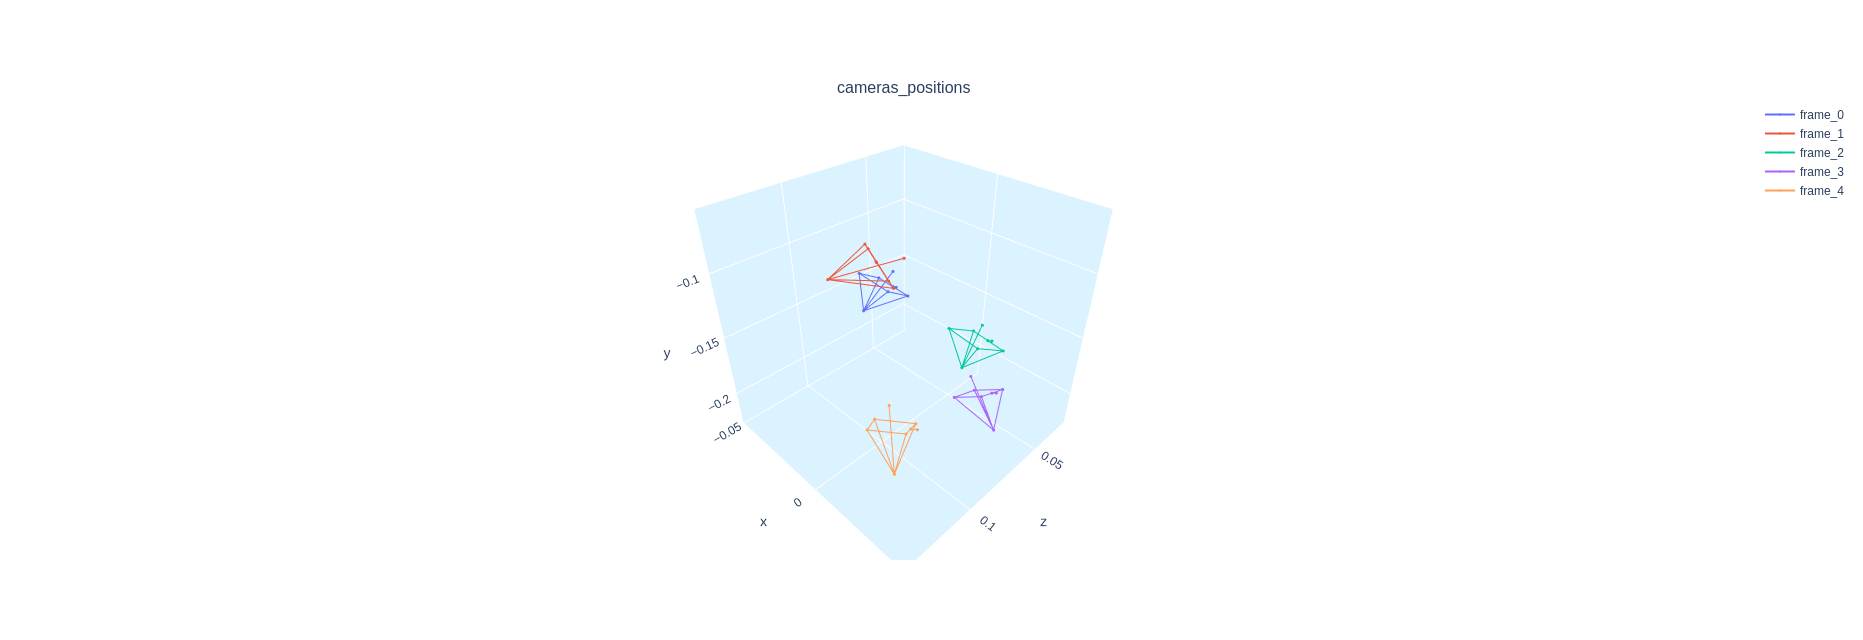

In [173]:
fig = plot_scene(
    rendered_cameras,
    camera_scale=0.01,
    axis_args=AxisArgs(backgroundcolor="#dbf2ff", showgrid=True, showticklabels=True,showaxeslabels=True)
)
fig.update_layout(
    width=960,
    height=640
)
fig.show()